In [2]:
import pandas as pd
from datetime import datetime
from zoe import cases, query, pickle, find_previous, plot_study, plot_study_evolution

In [68]:
uk_active_cases = query("SELECT * FROM uk_active_cases", index='date')
uk_active_cases.index = pd.to_datetime(uk_active_cases.index, format='%Y%m%d')
uk_active_cases

,cartodb_id,the_geom,the_geom_webmercator,corrected_covid_positive
date,,,,
2020-06-12,29755,None,None,88386.201942
2020-06-13,29756,None,None,81648.285333
2020-06-14,29757,None,None,75422.648033
2020-06-15,29758,None,None,69729.549469
2020-06-16,29759,None,None,64740.457964
...,...,...,...,...
2021-02-05,29993,None,None,365690.213303
2021-02-06,29994,None,None,350363.355572
2021-02-07,29995,None,None,335246.420293


In [69]:
curr_date = uk_active_cases.index.max()
print(pickle(uk_active_cases, 'uk_active_cases', curr_date))

/Users/chris/coronavirus/data/zoe_uk_active_cases_2021-02-09_2021-02-09-16-14.pickle


In [70]:
prev_date, prev_uk_active_cases = find_previous(curr_date)

/Users/chris/coronavirus/data/zoe_uk_active_cases_2021-02-06_2021-02-07-16-28.pickle


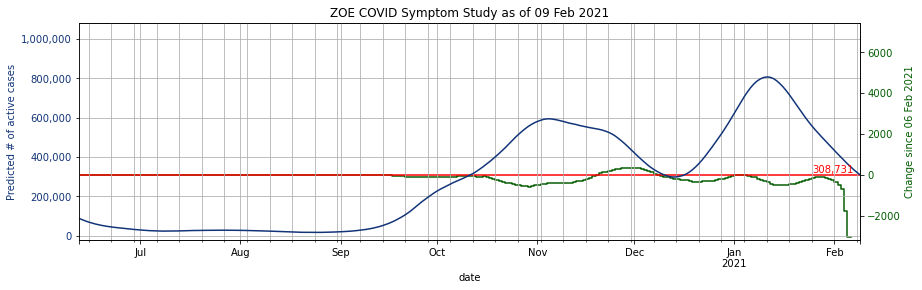

In [71]:
plot_study(curr_date, prev_date, uk_active_cases, prev_uk_active_cases)

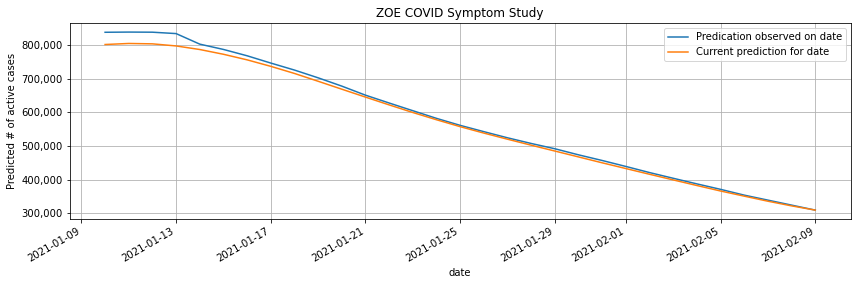

In [72]:
plot_study_evolution(curr_date, days=30)

In [73]:
prevalence_map = query("SELECT * FROM prevalence_map")
prevalence_map['percentage'] = prevalence_map['percentage'].astype(float)

In [74]:
for_date, = prevalence_map['data_status'].unique()
print(pickle(prevalence_map, 'prevalence_map', datetime.strptime(for_date, '%H:%M:%S %d-%m-%Y')))

/Users/chris/coronavirus/data/zoe_prevalence_map_2021-02-09_2021-02-09-16-14.pickle


In [75]:
prevalence_map[['lad16nm', 'lad16cd', 'percentage']].sort_values('percentage', ascending=False)[:10]

,lad16nm,lad16cd,percentage
334,Wrexham,W06000006,2.485724
277,St. Helens,E08000013,1.472132
337,Carmarthenshire,W06000010,1.430235
180,Cannock Chase,E07000192,1.371350
100,Erewash,E07000036,1.319724
208,Forest Heath,E07000201,1.285441
54,Luton,E06000032,1.261113
352,Hounslow,E09000018,1.224402
339,Swansea,W06000011,1.164080
99,Derbyshire Dales,E07000035,1.110137
